In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [ ]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [ ]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [ ]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

In [ ]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
# Function to forecast future prices
def forecast_future(model, data, steps, scaler, sequence_length=30):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = prediction[0, 0]

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(forecast)
    return forecast_prices.flatten()

In [ ]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [ ]:
# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [ ]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

In [ ]:
# Function to process the dataset and plot the results
def process_dataset(df, dataset_name, sequence_length=30, split_ratio=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']].values)
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

    # Predictions
    predicted_prices = model.predict(X_test)

    # Inverse transform to get actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predicted_prices_actual = scaler.inverse_transform(predicted_prices).flatten()

    # Evaluation
    mae, mape, rmse = evaluate_model(actual_prices, predicted_prices_actual)

    # Forecast future prices
    future_steps = 30
    future_forecast_1 = forecast_future(model, scaled_data, future_steps, scaler)
    future_forecast_2 = forecast_future(model, scaler.transform(future_forecast_1.reshape(-1, 1)), future_steps, scaler)
    future_forecast_3 = forecast_future(model, scaler.transform(future_forecast_2.reshape(-1, 1)), future_steps, scaler)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    future_dates_1 = pd.date_range(df['Date'].iloc[-1], periods=future_steps + 1)[1:]
    future_dates_2 = pd.date_range(future_dates_1[-1], periods=future_steps + 1)[1:]
    future_dates_3 = pd.date_range(future_dates_2[-1], periods=future_steps + 1)[1:]

    plt.plot(future_dates_1, future_forecast_1, color='red', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(future_dates_2, future_forecast_2, color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(future_dates_3, future_forecast_3, color='brown', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'LSTM {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

In [ ]:
# Define datasets and split ratios
datasets = {'Bitcoin': bitcoin_df, 'NASDAQ': nasdaq_df, 'US Dollar Index': usd_df}
split_ratios = [0.7, 0.8, 0.6]

Epoch 1/100
41/41 [==============================] - 12s 130ms/step - loss: 4.9524e-04 - val_loss: 0.0017
Epoch 2/100
41/41 [==============================] - 4s 103ms/step - loss: 1.0668e-04 - val_loss: 0.0017
Epoch 3/100
41/41 [==============================] - 3s 74ms/step - loss: 1.0063e-04 - val_loss: 0.0017
Epoch 4/100
41/41 [==============================] - 3s 75ms/step - loss: 8.2647e-05 - val_loss: 0.0011
Epoch 5/100
41/41 [==============================] - 3s 74ms/step - loss: 8.3323e-05 - val_loss: 0.0012
Epoch 6/100
41/41 [==============================] - 4s 97ms/step - loss: 7.0345e-05 - val_loss: 0.0012
Epoch 7/100
41/41 [==============================] - 4s 87ms/step - loss: 6.4408e-05 - val_loss: 0.0012
Epoch 8/100
41/41 [==============================] - 3s 74ms/step - loss: 6.3556e-05 - val_loss: 9.7594e-04
Epoch 9/100
41/41 [==============================] - 3s 74ms/step - loss: 6.5499e-05 - val_loss: 0.0017
Epoch 10/100
41/41 [==============================] - 3s 

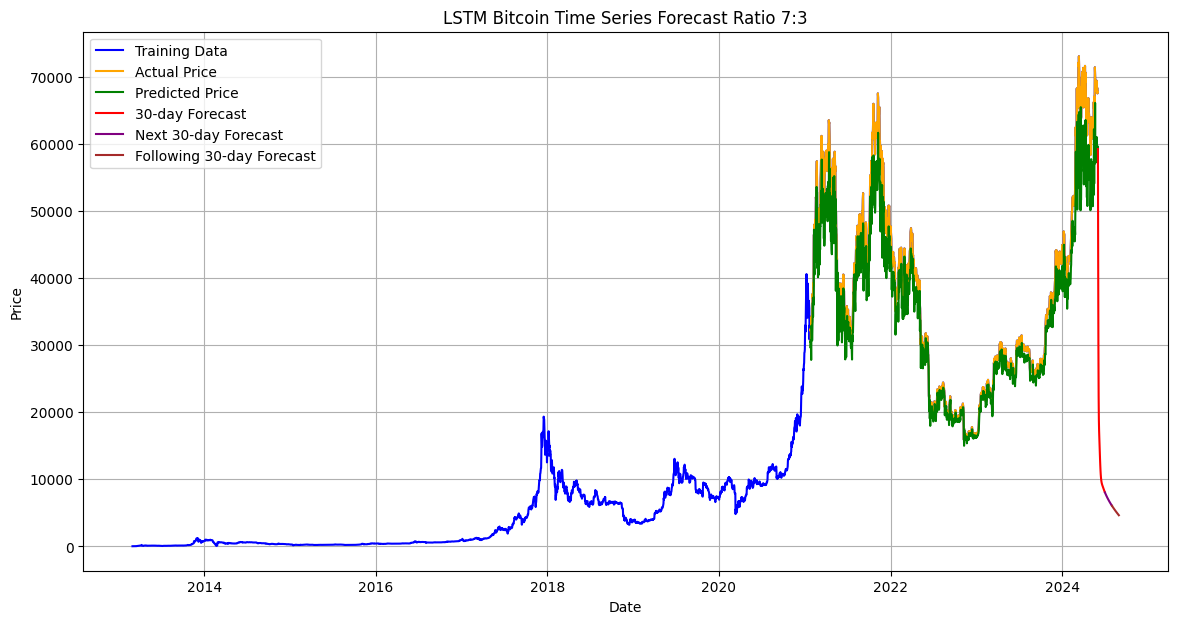

Bitcoin Results (Ratio 7:3): MAE: 3082.0686, RMSE: 4260.8380, MAPE: 6.93%
Epoch 1/100
46/46 [==============================] - 11s 117ms/step - loss: 0.0039 - val_loss: 0.0121
Epoch 2/100
46/46 [==============================] - 4s 84ms/step - loss: 3.9554e-04 - val_loss: 0.0046
Epoch 3/100
46/46 [==============================] - 3s 70ms/step - loss: 4.1047e-04 - val_loss: 0.0095
Epoch 4/100
46/46 [==============================] - 3s 69ms/step - loss: 3.5524e-04 - val_loss: 0.0079
Epoch 5/100
46/46 [==============================] - 4s 83ms/step - loss: 3.2056e-04 - val_loss: 0.0098
Epoch 6/100
46/46 [==============================] - 4s 89ms/step - loss: 2.7069e-04 - val_loss: 0.0056
Epoch 7/100
46/46 [==============================] - 3s 70ms/step - loss: 2.8072e-04 - val_loss: 0.0043
Epoch 8/100
46/46 [==============================] - 3s 69ms/step - loss: 3.0543e-04 - val_loss: 0.0044
Epoch 9/100
46/46 [==============================] - 4s 78ms/step - loss: 3.2466e-04 - val_loss:

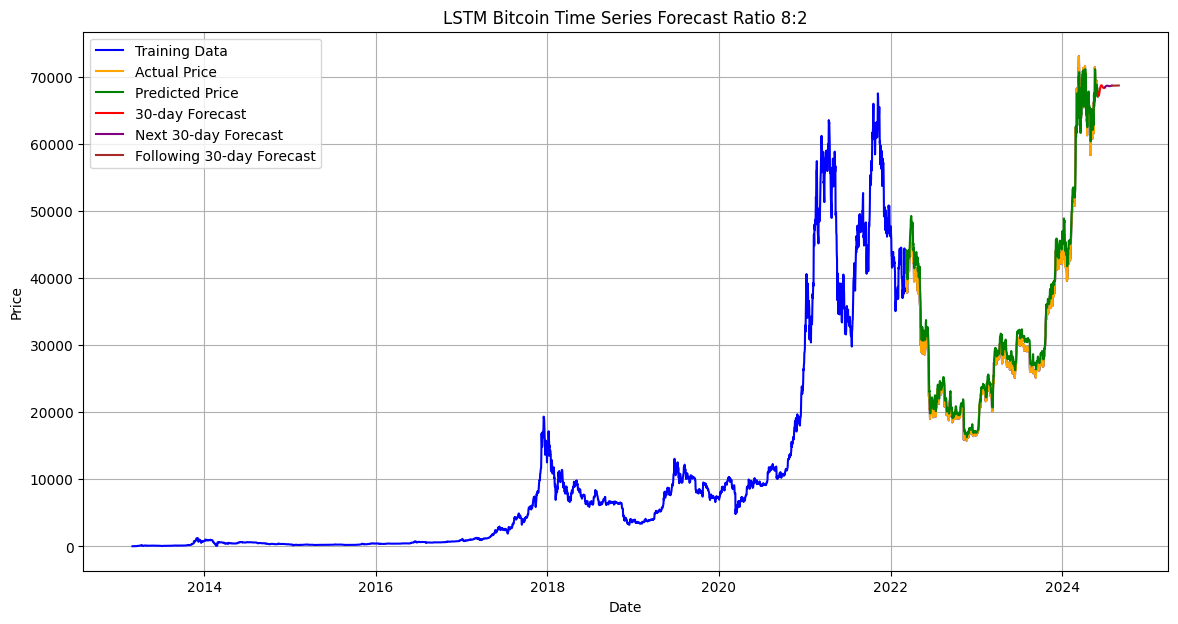

Bitcoin Results (Ratio 8:2): MAE: 1302.6634, RMSE: 1632.3766, MAPE: 4.07%
Epoch 1/100
35/35 [==============================] - 13s 139ms/step - loss: 7.5078e-04 - val_loss: 4.5240e-04
Epoch 2/100
35/35 [==============================] - 4s 104ms/step - loss: 1.2183e-04 - val_loss: 1.9553e-04
Epoch 3/100
35/35 [==============================] - 3s 82ms/step - loss: 1.0348e-04 - val_loss: 1.8818e-04
Epoch 4/100
35/35 [==============================] - 3s 81ms/step - loss: 8.5292e-05 - val_loss: 1.5646e-04
Epoch 5/100
35/35 [==============================] - 3s 82ms/step - loss: 8.4134e-05 - val_loss: 1.6528e-04
Epoch 6/100
35/35 [==============================] - 4s 105ms/step - loss: 6.8772e-05 - val_loss: 2.9525e-04
Epoch 7/100
35/35 [==============================] - 3s 96ms/step - loss: 7.0274e-05 - val_loss: 2.1212e-04
Epoch 8/100
35/35 [==============================] - 3s 81ms/step - loss: 7.9556e-05 - val_loss: 1.3394e-04
Epoch 9/100
35/35 [==============================] - 3s 80

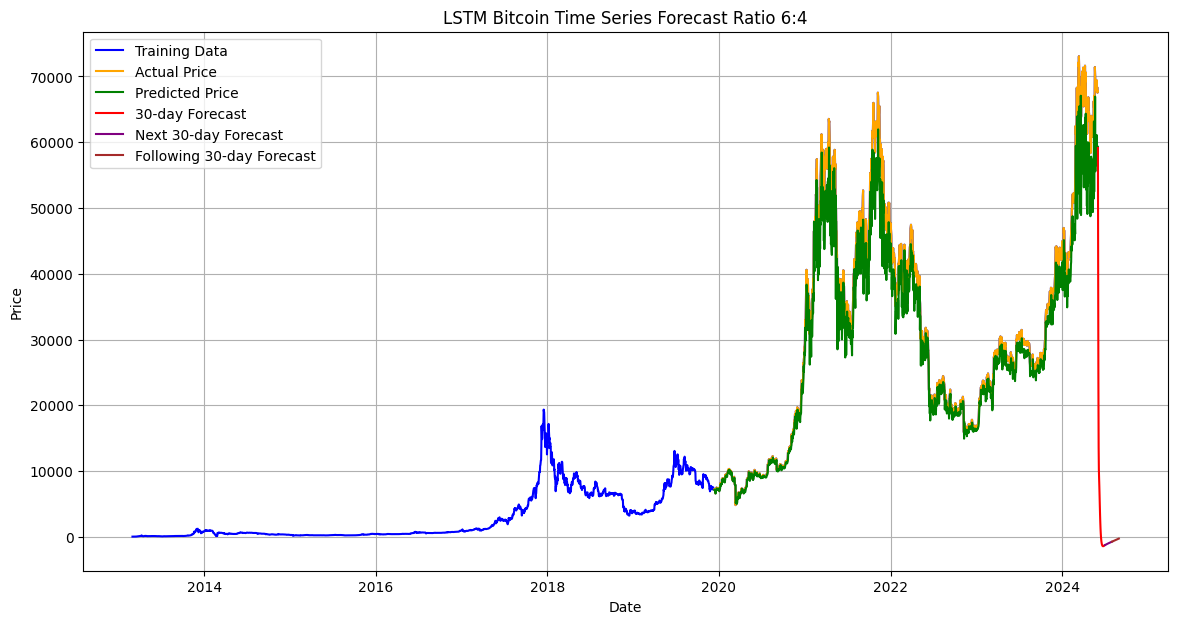

Bitcoin Results (Ratio 6:4): MAE: 2597.5395, RMSE: 3970.0929, MAPE: 6.44%
Epoch 1/100
28/28 [==============================] - 11s 130ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 2/100
28/28 [==============================] - 2s 77ms/step - loss: 4.2313e-04 - val_loss: 0.0040
Epoch 3/100
28/28 [==============================] - 2s 84ms/step - loss: 2.8132e-04 - val_loss: 0.0020
Epoch 4/100
28/28 [==============================] - 3s 109ms/step - loss: 2.4663e-04 - val_loss: 0.0022
Epoch 5/100
28/28 [==============================] - 3s 91ms/step - loss: 2.4529e-04 - val_loss: 0.0016
Epoch 6/100
28/28 [==============================] - 2s 77ms/step - loss: 2.2793e-04 - val_loss: 0.0021
Epoch 7/100
28/28 [==============================] - 2s 79ms/step - loss: 2.2414e-04 - val_loss: 0.0031
Epoch 8/100
28/28 [==============================] - 2s 81ms/step - loss: 2.3829e-04 - val_loss: 0.0024
Epoch 9/100
28/28 [==============================] - 2s 80ms/step - loss: 2.4470e-04 - val_loss

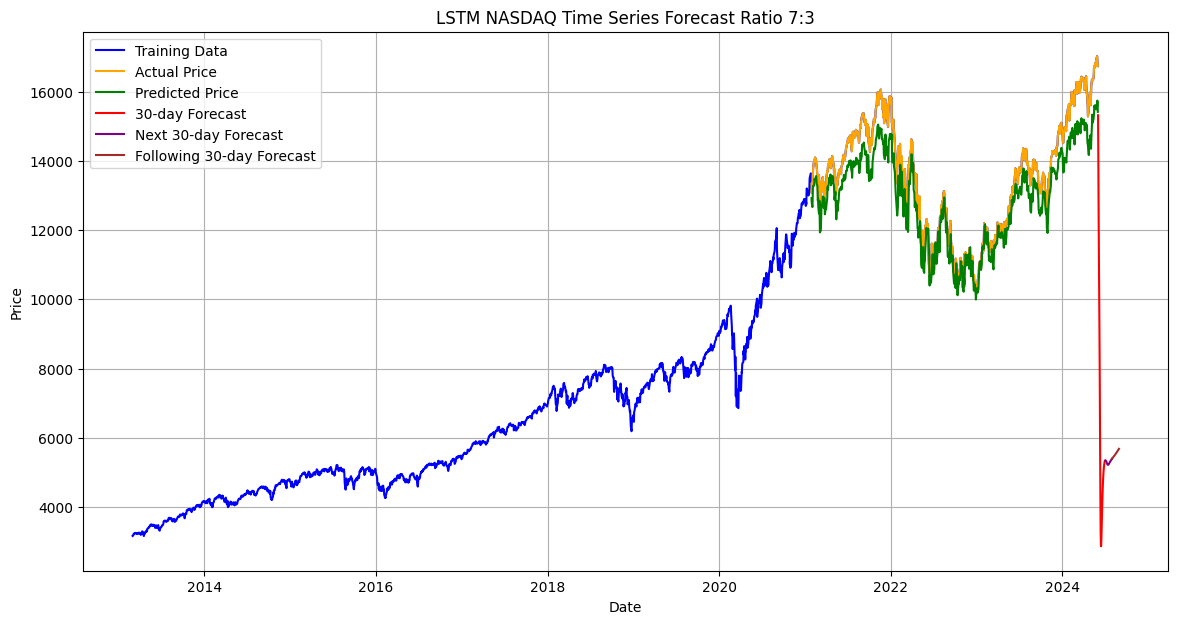

NASDAQ Results (Ratio 7:3): MAE: 612.8899, RMSE: 712.2704, MAPE: 4.33%
Epoch 1/100
32/32 [==============================] - 11s 144ms/step - loss: 0.0122 - val_loss: 0.0084
Epoch 2/100
32/32 [==============================] - 2s 72ms/step - loss: 5.9147e-04 - val_loss: 0.0025
Epoch 3/100
32/32 [==============================] - 2s 72ms/step - loss: 3.5566e-04 - val_loss: 0.0014
Epoch 4/100
32/32 [==============================] - 2s 72ms/step - loss: 3.3083e-04 - val_loss: 0.0013
Epoch 5/100
32/32 [==============================] - 3s 84ms/step - loss: 3.2033e-04 - val_loss: 0.0011
Epoch 6/100
32/32 [==============================] - 3s 103ms/step - loss: 3.0538e-04 - val_loss: 0.0011
Epoch 7/100
32/32 [==============================] - 3s 79ms/step - loss: 3.1611e-04 - val_loss: 0.0011
Epoch 8/100
32/32 [==============================] - 2s 71ms/step - loss: 3.0660e-04 - val_loss: 0.0014
Epoch 9/100
32/32 [==============================] - 2s 71ms/step - loss: 2.9797e-04 - val_loss: 0

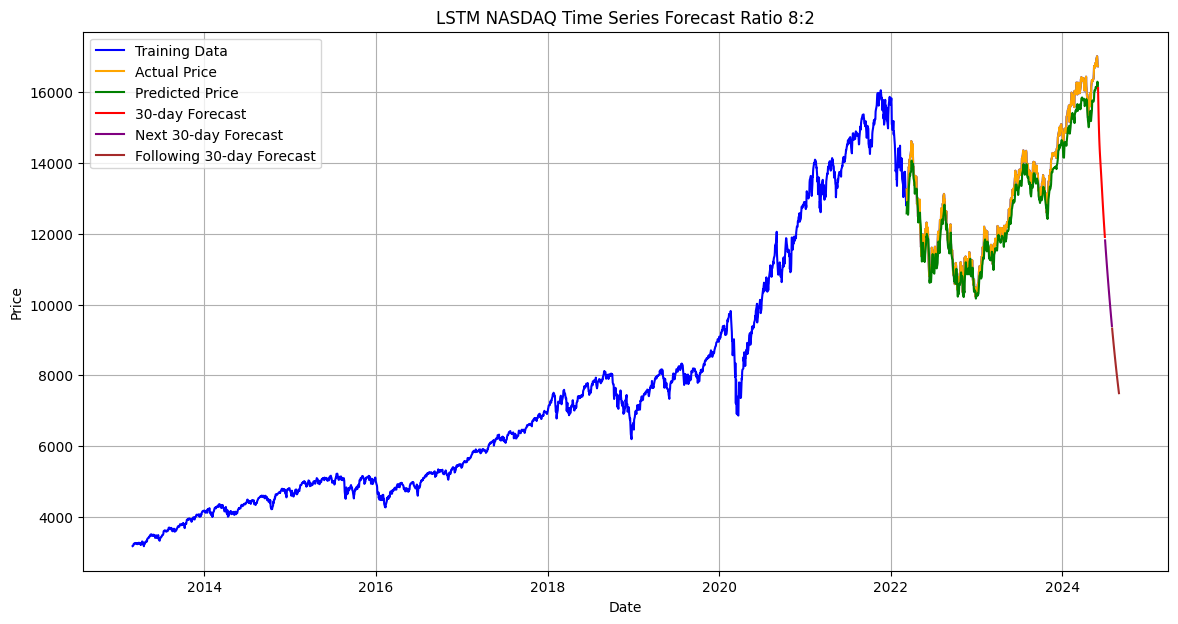

NASDAQ Results (Ratio 8:2): MAE: 334.2460, RMSE: 390.2781, MAPE: 2.48%
Epoch 1/100
24/24 [==============================] - 10s 130ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 2/100
24/24 [==============================] - 2s 71ms/step - loss: 2.1107e-04 - val_loss: 2.1353e-04
Epoch 3/100
24/24 [==============================] - 2s 90ms/step - loss: 1.1636e-04 - val_loss: 2.1427e-04
Epoch 4/100
24/24 [==============================] - 2s 104ms/step - loss: 1.1374e-04 - val_loss: 2.0774e-04
Epoch 5/100
24/24 [==============================] - 2s 93ms/step - loss: 1.1186e-04 - val_loss: 2.1739e-04
Epoch 6/100
24/24 [==============================] - 2s 72ms/step - loss: 1.0900e-04 - val_loss: 2.0845e-04
Epoch 7/100
24/24 [==============================] - 2s 71ms/step - loss: 1.1158e-04 - val_loss: 2.1803e-04
Epoch 8/100
24/24 [==============================] - 2s 71ms/step - loss: 1.0913e-04 - val_loss: 1.9601e-04
Epoch 9/100
24/24 [==============================] - 2s 71ms/step - lo

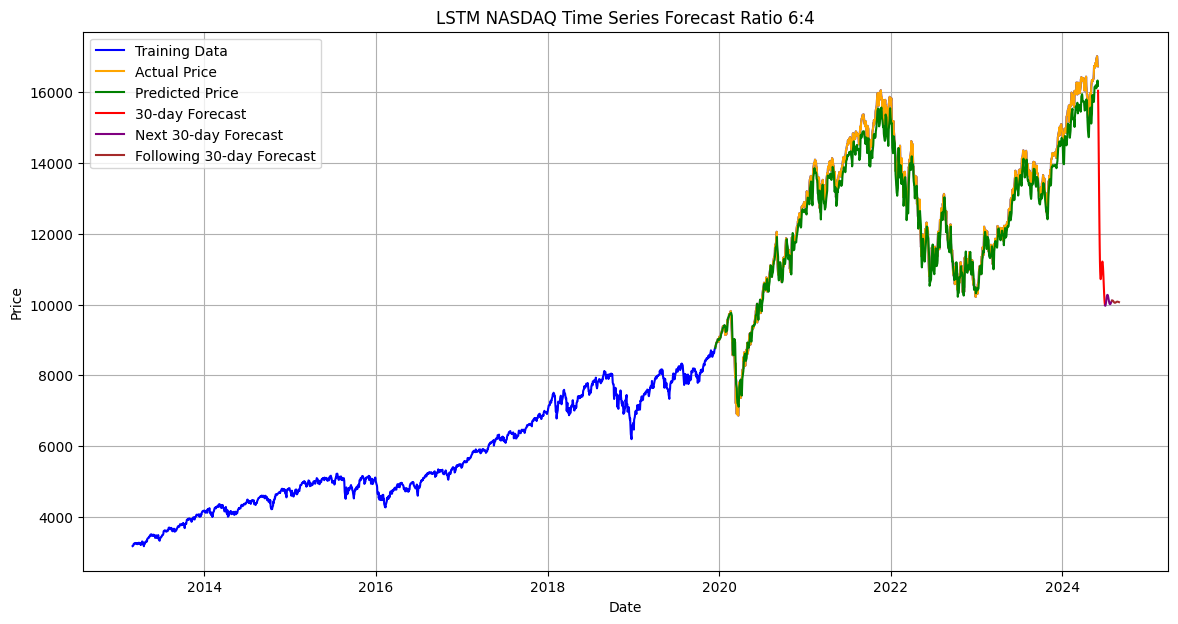

NASDAQ Results (Ratio 6:4): MAE: 290.7138, RMSE: 358.6952, MAPE: 2.21%
Epoch 1/100
29/29 [==============================] - 11s 160ms/step - loss: 0.0232 - val_loss: 0.0017
Epoch 2/100
29/29 [==============================] - 3s 88ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/100
29/29 [==============================] - 2s 70ms/step - loss: 0.0011 - val_loss: 9.0696e-04
Epoch 4/100
29/29 [==============================] - 2s 71ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 5/100
29/29 [==============================] - 2s 70ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/100
29/29 [==============================] - 2s 71ms/step - loss: 9.8543e-04 - val_loss: 9.1072e-04
Epoch 7/100
29/29 [==============================] - 3s 90ms/step - loss: 9.7172e-04 - val_loss: 0.0012
Epoch 8/100
29/29 [==============================] - 3s 102ms/step - loss: 9.7064e-04 - val_loss: 0.0010
Epoch 9/100
29/29 [==============================] - 2s 84ms/step - loss: 9.2544e-04 - val_loss: 0.0012
Ep

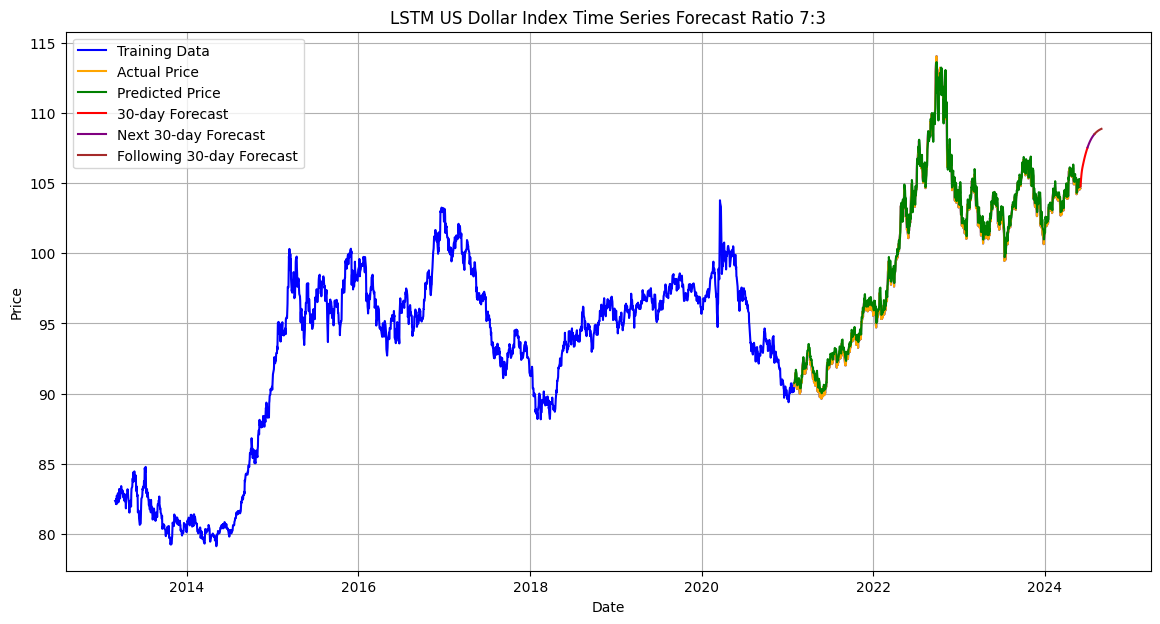

US Dollar Index Results (Ratio 7:3): MAE: 0.4119, RMSE: 0.5275, MAPE: 0.41%
Epoch 1/100
33/33 [==============================] - 10s 124ms/step - loss: 0.0198 - val_loss: 0.0015
Epoch 2/100
33/33 [==============================] - 4s 111ms/step - loss: 0.0014 - val_loss: 5.4175e-04
Epoch 3/100
33/33 [==============================] - 3s 97ms/step - loss: 9.2502e-04 - val_loss: 5.4704e-04
Epoch 4/100
33/33 [==============================] - 3s 81ms/step - loss: 9.2239e-04 - val_loss: 6.2895e-04
Epoch 5/100
33/33 [==============================] - 3s 81ms/step - loss: 9.0154e-04 - val_loss: 6.0136e-04
Epoch 6/100
33/33 [==============================] - 3s 80ms/step - loss: 8.8939e-04 - val_loss: 5.5533e-04
Epoch 7/100
33/33 [==============================] - 3s 103ms/step - loss: 8.6261e-04 - val_loss: 5.0018e-04
Epoch 8/100
33/33 [==============================] - 4s 105ms/step - loss: 8.4997e-04 - val_loss: 5.3856e-04
Epoch 9/100
33/33 [==============================] - 3s 81ms/step -

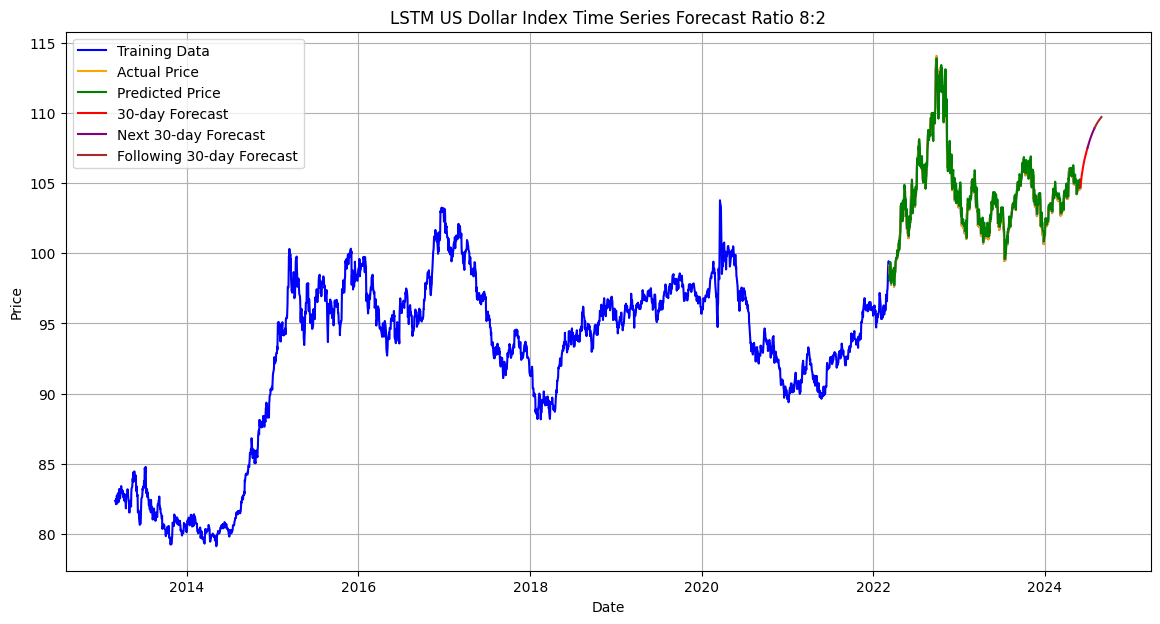

US Dollar Index Results (Ratio 8:2): MAE: 0.4186, RMSE: 0.5525, MAPE: 0.40%
Epoch 1/100
25/25 [==============================] - 10s 163ms/step - loss: 0.0255 - val_loss: 0.0036
Epoch 2/100
25/25 [==============================] - 3s 112ms/step - loss: 0.0023 - val_loss: 6.0901e-04
Epoch 3/100
25/25 [==============================] - 2s 80ms/step - loss: 0.0011 - val_loss: 3.2446e-04
Epoch 4/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0011 - val_loss: 3.1190e-04
Epoch 5/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0011 - val_loss: 3.5355e-04
Epoch 6/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0010 - val_loss: 3.0182e-04
Epoch 7/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0010 - val_loss: 3.0416e-04
Epoch 8/100
25/25 [==============================] - 2s 101ms/step - loss: 9.8007e-04 - val_loss: 3.0414e-04
Epoch 9/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0010 - val_

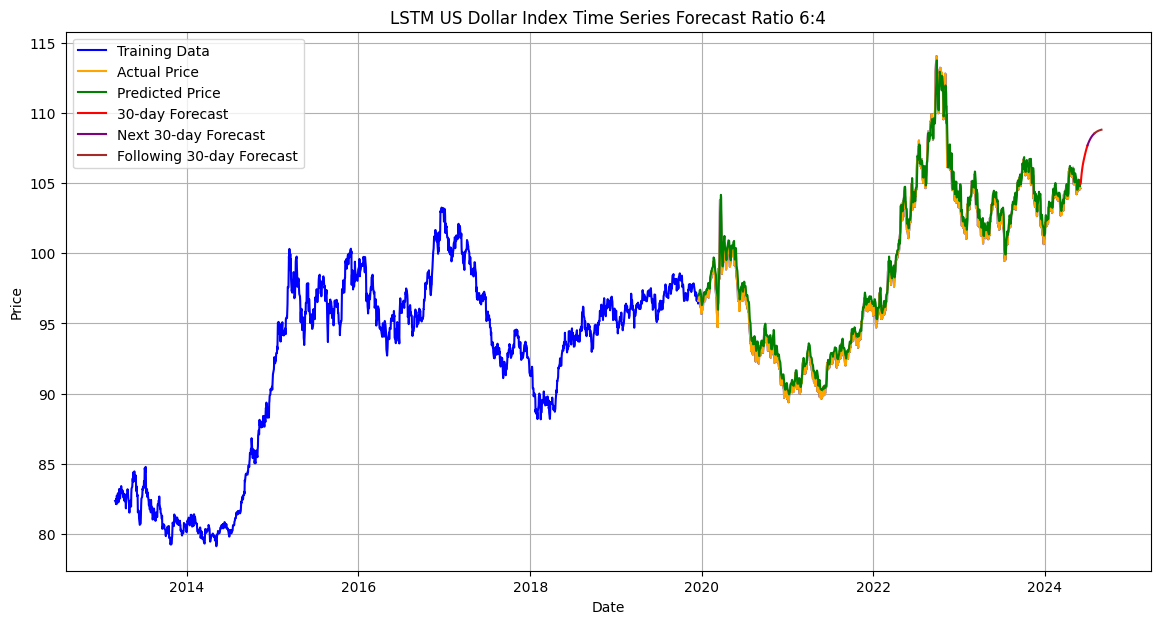

US Dollar Index Results (Ratio 6:4): MAE: 0.5050, RMSE: 0.6392, MAPE: 0.51%


In [ ]:
# Process each dataset with different split ratios
for dataset_name, df in datasets.items():
    for split_ratio in split_ratios:
        results = process_dataset(df, dataset_name, split_ratio=split_ratio)
        print(f'{dataset_name} Results (Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}): MAE: {results["mae"]:.4f}, RMSE: {results["rmse"]:.4f}, MAPE: {results["mape"]:.2f}%')